### Friends data에 대한 감정분석

#### 패키지 설치 및 환경 세팅

In [2]:
!pip install transformers

     |████████████████████████████████| 1.5MB 13.6MB/s 
     |████████████████████████████████| 890kB 46.4MB/s 
     |████████████████████████████████| 2.9MB 49.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=5c59c8a0785b5e091c040921b1944837c01cd60bfdc15021fdf82bc29e520769
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# 환경 세팅
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import nltk
nltk.download("book", quiet=True)
from nltk.book import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import datetime
import json

In [4]:
# friends 데이터 불러오기
!git clone https://github.com/yakpanda/Sentiment-Analysis.git
with open('Sentiment-Analysis/friends_dev.json', 'r') as f:
    json_dev = json.load(f)
with open('Sentiment-Analysis/friends_train.json', 'r') as f:
    json_train = json.load(f)
with open('Sentiment-Analysis/friends_test.json', 'r') as f:
    json_test = json.load(f)

Cloning into 'Sentiment-Analysis'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 29 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [14]:
# json 데이터 판다스에 저장
dev = pd.DataFrame(columns=['speaker', 'utterance', 'emotion', 'annotation'])
train = pd.DataFrame(columns=['speaker', 'utterance', 'emotion', 'annotation'])
test = pd.DataFrame(columns=['speaker', 'utterance', 'emotion', 'annotation'])
for i in range(len(json_dev)):
    df = pd.DataFrame.from_dict(pd.json_normalize(json_train[i]), orient='columns')
    dev = dev.append(df)
for i in range(len(json_train)):
    df = pd.DataFrame.from_dict(pd.json_normalize(json_train[i]), orient='columns')
    train = train.append(df)
for i in range(len(json_test)):
    df = pd.DataFrame.from_dict(pd.json_normalize(json_test[i]), orient='columns')
    test = test.append(df)

train = train.append(dev)

print(train.shape)
print(test.shape)

(11779, 4)
(2764, 4)


In [6]:
# speaker와 대사 합치기
train['blank'] = ' '
train['full'] = train['speaker'] + train['blank'] + train['utterance']

In [7]:
train.head()

,speaker,utterance,emotion,annotation,blank,full
0,Chandler,also I was the point person on my companys tr...,neutral,4100000,,Chandler also I was the point person on my com...
1,The Interviewer,You mustve had your hands full.,neutral,5000000,,The Interviewer You mustve had your hands full.
2,Chandler,That I did. That I did.,neutral,5000000,,Chandler That I did. That I did.
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000,,The Interviewer So lets talk a little bit abo...
4,Chandler,My duties? All right.,surprise,2000030,,Chandler My duties? All right.


In [9]:
# 소문자화
sentences = train['full']
sentences = [str(sentence).lower() for sentence in sentences]
sentences = [str(sentence).lower() for sentence in sentences]

In [11]:
# BERT special 토큰 추가
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
#sentences[:5]

# 레이블 추출
labels = train['emotion'].values
#labels

train['emotion'].unique()

# 레이블 인코딩
le = preprocessing.LabelEncoder()
le.fit(['neutral', 'surprise', 'fear', 'non-neutral', 'joy', 'sadness',
       'anger', 'disgust'])
le.classes_
labels = le.transform(labels)
labels

# 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [12]:
sentences[:5]

['[CLS] chandler also i was the point person on my company\x92s transition from the kl-5 to gr-6 system. [SEP]',
 '[CLS] the interviewer you must\x92ve had your hands full. [SEP]',
 '[CLS] chandler that i did. that i did. [SEP]',
 '[CLS] the interviewer so let\x92s talk a little bit about your duties. [SEP]',
 '[CLS] chandler my duties?  all right. [SEP]']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


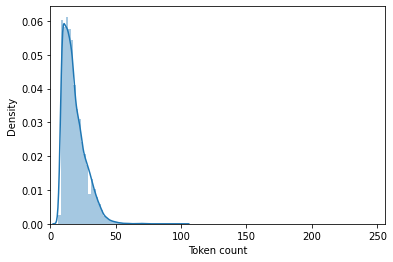

In [13]:
# 입력 토큰의 최대 길이 설정을 위한 확인
token_lens = []
for txt in sentences:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [16]:
# 최대 길이 설정
MAX_LEN = 50

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# MAX_LEN 길이에 맞추고 나머지 0으로 패딩
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# attention mask
attention_masks = []

# attention mask 패딩 아니면 1, 패딩이면 0
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

#print(attention_masks[0])

In [17]:
# train set validation set 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels,
                                                                                    random_state=22,
                                                                                    test_size=0.1)

# attention mask train set validation set 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=22,
                                                       test_size=0.1)

# tensor 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

# 배치 사이즈
batch_size = 32

# pytorch DataLoader로 input, mask, label 묶기
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#### Test data 세팅

In [18]:
test['blank'] = ' '
test['full'] = test['speaker'] + test['blank'] + test['utterance']
test.head()

,speaker,utterance,emotion,annotation,blank,full
0,Mark,Why do all youre coffee mugs have numbers on ...,surprise,2000030,,Mark Why do all youre coffee mugs have number...
1,Rachel,Oh. Thats so Monica can keep track. That way ...,non-neutral,2100011,,Rachel Oh. Thats so Monica can keep track. Th...
2,Rachel,Y'know what?,neutral,3000020,,Rachel Y'know what?
3,Ross,It didnt.,neutral,5000000,,Ross It didnt.
4,Frank,"Okay, so what you used to have with Rachel, is...",joy,1300010,,"Frank Okay, so what you used to have with Rach..."


In [19]:
sentences = test['full']
sentences = [str(sentence).lower() for sentence in sentences]
#sentences = [re.sub('\x92', ' ', str(sentence)) for sentence in sentences]
#sentences = [re.sub('\x85', ' ', str(sentence)) for sentence in sentences]
#sentences = [re.sub('\x91', ' ', str(sentence)) for sentence in sentences]
#sentences = [re.sub('\x97', ' ', str(sentence)) for sentence in sentences]
#sentences = [re.sub('\x93', ' ', str(sentence)) for sentence in sentences]

In [20]:
# BERT 스페셜 토큰 추가
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

# 레이블 추출
labels = test['emotion'].values
labels

# 레이블 인코딩
le = preprocessing.LabelEncoder()
le.fit(['neutral', 'surprise', 'fear', 'non-neutral', 'joy', 'sadness',
       'anger', 'disgust'])
le.classes_
labels = le.transform(labels)
labels

# BERT 토큰화
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# 문장 최대 길이
MAX_LEN = 50

# 토큰 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# MAX_LEN 길이에 맞추고 나머지 0으로 패딩
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# 어텐션 마스크
attention_masks = []

# 패딩 아니면 1, 패딩이면 0
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# 텐서로 변환
test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

# 배치 사이즈
batch_size = 32

# pytorch DataLoader로 input, mask, label 묶기
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [21]:
# GPU 디바이스 체크
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    device = torch.device("cpu")
    print(device)

cuda


In [22]:
# BERT 분류 모델 생성
# 영문 분석: bert-base-cased
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=8)
model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [23]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 2

# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(train_dataloader) * epochs

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [24]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
# 랜덤시드 고정
seed_val = 22
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복 학습
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('=== Epoch {:} / {:} ==='.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


=== Epoch 1 / 2 ===
Training...

  Average training loss: 1.32
  Training epcoh took: 0:00:41

Running Validation...
  Accuracy: 0.61
  Validation took: 0:00:01

=== Epoch 2 / 2 ===
Training...

  Average training loss: 1.03
  Training epcoh took: 0:00:40

Running Validation...
  Accuracy: 0.63
  Validation took: 0:00:01

Training complete!


In [27]:
from google.colab import files
# 모델 weight save
#torch.save(model.state_dict(), 'checkpoint_friends.pth')

# 다운로드
#files.download('checkpoint_friends.pth')

In [28]:
# 모델 weight load
#path = F"/content/drive/MyDrive/Colab Notebooks/NLP/기말_감정분석/checkpoint.pth"
#model.load_state_dict(torch.load(path))

#### 캐글 데이터 예측

In [29]:
# 캐글 데이터
url = 'https://raw.githubusercontent.com/yakpanda/Sentiment-Analysis/main/friends/en_data.csv'
kg = pd.read_csv(url)

In [30]:
kg.head()

,id,i_dialog,i_utterance,speaker,utterance
0,0,0,0,Phoebe,"Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!


In [31]:
# 화자와 대화 내용 합치기
kg['blank'] = ' '
kg['full'] = kg['speaker'] + kg['blank'] + kg['utterance']
kg.head()

,id,i_dialog,i_utterance,speaker,utterance,blank,full
0,0,0,0,Phoebe,"Alright, whadyou do with him?",,"Phoebe Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!,,Monica Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...,,Joey Then you gotta come clean with Ma! This i...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is",,"Mr. Tribbiani Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!,,Joey I don't wanna hear it! Now go to my room!


In [32]:
# 문장 추출
SA_text = kg.full
SA_text

0                    Phoebe Alright, whadyou do with him?
1                                Monica Oh! You're awake!
2       Joey Then you gotta come clean with Ma! This i...
3                         Mr. Tribbiani Yeah, but this is
4          Joey I don't wanna hear it! Now go to my room!
                              ...                        
1618                                           Joey Nooo.
1619                                     Lauren Hi, Kate!
1620                                     Kate Hi, Lauren.
1621                                     Joey Hi, Lauren.
1622                                      Lauren Hi, pig!
Name: full, Length: 1623, dtype: object

In [33]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 50

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [34]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [35]:
# 감정분석 결과
result = []
#for i in range(10):
for i in SA_text:
  #print(review_text[i])
  logits = test_sentences([i])
  result.append(np.argmax(logits))

In [36]:
le.classes_

array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'non-neutral',
       'sadness', 'surprise'], dtype='<U11')

In [37]:
# 예측 결과
result_df = pd.DataFrame(data=result, columns=['Predicted'])
result_df["Predicted"].replace({0: "anger", 1: "disgust", 2: "fear", 3: "joy",
                                4: "neutral", 5: "non-neutral", 6: "sadness", 7: "surprise"}, inplace=True)
result_df

,Predicted
0,non-neutral
1,joy
2,anger
3,neutral
4,non-neutral
...,...
1618,non-neutral
1619,joy
1620,neutral
1621,neutral


In [ ]:
result_df.to_csv('en_data.csv')
files.download('en_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>